# Simulating backends with `DynamicsBackend`

In this tutorial we walk through how to use the `DynamicsBackend` class as a Dynamics-backed simulator of a real backend. In particular, we demonstrate how to add various levels of configuration to the `DynamicsBackend` to enable simulation of pulse schedules, circuits with gate with pulse definitions, and calibration and characterization experiments from Qiskit Experiments.

The sections of this tutorial are as follows:
1. Configure Dynamics to use JAX.
2. Instantiating a minimally-configured `DynamicsBackend` with a 2 qubit model. 
3. Simulating pulse schedules on the `DynamicsBackend`.
4. Simulating circuits at the pulse level using the `DynamicsBackend`.
5. Simulating single-qubit calibration processes via Qiskit Experiments.
6. Simulating 2 qubit interaction characterization via the `CrossResonanceHamiltonian` experiment.

## 1. Configure Dynamics to use JAX

Note that the `DynamicsBackend` internally performs just-in-time compilation automatically when configured to use JAX.

In [1]:
# Configure to use JAX internally
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')
from qiskit_dynamics.array import Array
Array.set_default_backend('jax')

## 2. Instantiating a `DynamicsBackend`

To create the `DynamicsBackend`, first specify a `Solver` instance using the model details.

**To do: Fill out model description here once exact parameters/source finalized. What level of detail?**

In [3]:
import numpy as np

dim = 3

v0 = 5.08251096222196e9
anharm0 = -0.3423508217039861e9
r0 = 0.17726788203028987e9

v1 = 5.144019074622987e9
anharm1 = -0.4050453261341784e9
r1 = 0.20507147047958452e9

J = 0.0032326059164651706e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**2, dtype=complex)

N0 = np.kron(ident, N)
N1 = np.kron(N, ident)

a0 = np.kron(ident, a)
a1 = np.kron(a, ident)

a0dag = np.kron(ident, adag)
a1dag = np.kron(adag, ident)


static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))

drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

Construct the `Solver` using the model details, including parameters necessary for pulse simulation.

**To do: add reference to tutorial on pulse simulation for more details.**

In [4]:
from qiskit_dynamics import Solver

# build solver
dt = 1/4.5e9

solver = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
    rotating_frame=static_ham_full,
    hamiltonian_channels=['d0', 'd1', 'u0', 'u1'],
    channel_carrier_freqs={'d0': v0, 'd1': v1, 'u0': v1, 'u1': v0},
    dt=dt,
)

Next, instantiate the `DynamicsBackend`. The `solver` is used for simulation, `subsystem_dims` indicates how the full system decomposes for measurement data computation, `control_channel_map` indicates the labelling of each control channel, and `solver_options` are consistent options used by `Solver.solve` when simulating the differential equation.

Note that, to enable the internal automatic jit-compilation, we choose a JAX integration method.

In [5]:
from qiskit_dynamics import DynamicsBackend

# Consistent solver option to use throughout notebook
solver_options = {'method': 'jax_odeint', 'atol': 1e-6, 'rtol': 1e-8}

backend = DynamicsBackend(
    solver=solver,
    subsystem_dims=[dim, dim], # for computing measurement data
    control_channel_map={(0, 1): 0, (1, 0): 1},
    solver_options=solver_options, # to be used every time run is called
)

## 3. Simulate a list of schedules

With the above backend, we can already simulate a list of pulse schedules. The code below generates a list of schedules specifying experiments on qubit 0. The schedule is chosen to demonstrate that the usual instructions work on the `DynamicsBackend`.

In [6]:
%%time

from qiskit import pulse

sigma = 128
num_samples = 256

schedules = []

for amp in np.linspace(0., 1., 10):
    gauss = pulse.library.Gaussian(
        num_samples, amp, sigma, name="Parametric Gauss"
    )

    with pulse.build() as schedule:
        with pulse.align_right():
            pulse.play(gauss, pulse.DriveChannel(0))
            pulse.shift_phase(0.5, pulse.DriveChannel(0))
            pulse.shift_frequency(0.1, pulse.DriveChannel(0))
            pulse.play(gauss, pulse.DriveChannel(0))
            pulse.acquire(duration=1, qubit_or_channel=0, register=pulse.MemorySlot(0))
        
    schedules.append(schedule)
    
job = backend.run(schedules, shots=100)
result = job.result()

CPU times: user 2.01 s, sys: 63 ms, total: 2.07 s
Wall time: 2.06 s


Retrieve the counts for one of the experiments as would be done using the results object from a real backend.

In [7]:
result.get_counts(4)

{'0': 40, '1': 60}

## 4. Simulating circuits at the pulse level using `DynamicsBackend`

For the `DynamicsBackend` to simulate a circuit, each circuit element must have a corresponding pulse schedule. These schedules can either be specified in the gates themselves, by attaching calibrations, or by adding instructions to the `Target` contained in the `DynamicsBackend`.

### 4.1 Simulating circuits with attached calibrations

Build a simple circuit. Here we build one consisting of a single Hadamard gate on qubit 0, followed by measurement.

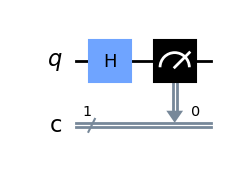

In [8]:
from qiskit import QuantumCircuit

circ = QuantumCircuit(1, 1)
circ.h(0)
circ.measure([0], [0])

circ.draw("mpl")

Next, attach a calibration for the Hadamard gate on qubit 0 to the circuit. Note that here are only demonstrating the mechanics of adding a calibration; we have not actually chosen the pulse to implement a Hadamard gate.

In [9]:
with pulse.build() as h_q0:
    pulse.play(
        pulse.library.Gaussian(duration=256, amp=0.2, sigma=50, name='custom'),
        pulse.DriveChannel(0)
    )

circ.add_calibration('h', [0], h_q0)

Call run on the circuit, and get counts as usual.

In [10]:
%time res = backend.run(circ).result()

res.get_counts(0)

CPU times: user 1.1 s, sys: 41.3 ms, total: 1.14 s
Wall time: 1.12 s


{'0': 973, '1': 51}

### 4.2 Simulating circuits via gate definitions in the backend `Target`

Alternatively to the above work flow, add the above schedule as the pulse-level definition of the Hadamard gate on qubit 0.

In [11]:
from qiskit.circuit.library import HGate
from qiskit.transpiler import InstructionProperties

backend.target.add_instruction(HGate(), {(0,): InstructionProperties(calibration=h_q0)})

Rebuild the same circuit, however this time we do not need to add the calibration for the Hadamard gate to the circuit object.

In [12]:
circ2 = QuantumCircuit(1, 1)
circ2.h(0)
circ2.measure([0], [0])

%time result = backend.run(circ2).result()

CPU times: user 1.02 s, sys: 41.5 ms, total: 1.06 s
Wall time: 1.04 s


In [13]:
result.get_counts(0)

{'0': 976, '1': 48}

## 5. Simulating calibration of single qubit gates using Qiskit Experiments

Next, we calibrate `X` and `SX` gates on both qubits modeled in the `DynamicsBackend`.

**To do: add reference to the single qubit calibration tutorial for Qiskit Experiments and say that we're walking through this.**

### 5.1 Configure the `Target` to include single qubit instructions

To enable running of the single qubit experiments, we add the following to the target:
- Qubit frequency properties (needed by the `RoughFrequencyCal` experiment).
- `X` and `SX` gate instructions, which the transpiler needs to check are supported by the backend.
- Add definitions of `RZ` gates as phase shifts.

In [14]:
from qiskit.circuit.library import XGate, SXGate, RZGate
from qiskit.circuit import Parameter
from qiskit.providers.backend import QubitProperties

target = backend.target

# qubit properties
target.qubit_properties = [QubitProperties(frequency=v0), QubitProperties(frequency=v1)]

# add instructions
target.add_instruction(XGate())
target.add_instruction(SXGate())

# Add RZ instruction as phase shift for drag cal
phi = Parameter('phi')
with pulse.build() as rz0:
    pulse.shift_phase(phi, pulse.DriveChannel(0))

with pulse.build() as rz1:
    pulse.shift_phase(phi, pulse.DriveChannel(1))

target.add_instruction(
    RZGate(phi),
    {(0,): InstructionProperties(calibration=rz0), (1,): InstructionProperties(calibration=rz1)}
)

### 5.2 Prepare `Calibrations` object

Following **insert link to tutorial**, we prepare the `Calibrations` object.

**TO DO: insert link above**

In [15]:
import pandas as pd
from qiskit_experiments.calibration_management.calibrations import Calibrations

cals = Calibrations()

dur = Parameter("dur")
sigma = Parameter("σ")
drive = pulse.DriveChannel(Parameter("ch0"))

# Define and add template schedules.
with pulse.build(name="x") as x:
    pulse.play(pulse.Drag(dur, Parameter("amp"), sigma, Parameter("β")), drive)

with pulse.build(name="sx") as sx:
    #pulse.play(pulse.Drag(dur, Parameter("amp"), sigma, Parameter("β")), drive)
    pulse.play(pulse.Drag(dur, Parameter("amp"), sigma, Parameter("β")), drive)

cals.add_schedule(x, num_qubits=1)
cals.add_schedule(sx, num_qubits=1)

# add parameter guesses
for sched in ["x", "sx"]:
    cals.add_parameter_value(80, "σ", schedule=sched)
    cals.add_parameter_value(0.5, "β", schedule=sched)
    cals.add_parameter_value(320, "dur", schedule=sched)
    cals.add_parameter_value(0.5, "amp", schedule=sched)

pd.DataFrame(**cals.parameters_table(qubit_list=[0, ()]))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,β,(),x,0.5,default,True,2023-02-14 10:26:32.650032-0800,None
1,σ,(),x,80.0,default,True,2023-02-14 10:26:32.645476-0800,None
2,dur,(),sx,320.0,default,True,2023-02-14 10:26:32.656648-0800,None
3,amp,(),sx,0.5,default,True,2023-02-14 10:26:32.658412-0800,None
4,dur,(),x,320.0,default,True,2023-02-14 10:26:32.650529-0800,None
5,amp,(),x,0.5,default,True,2023-02-14 10:26:32.651462-0800,None
6,β,(),sx,0.5,default,True,2023-02-14 10:26:32.656151-0800,None
7,σ,(),sx,80.0,default,True,2023-02-14 10:26:32.654436-0800,None


### 5.3 Rough frequency cals

Run frequency calibration experiments. We perturb the frequency estimate to imitate not knowing the frequency ahead of time.

In [16]:
from qiskit_experiments.library.calibration.rough_frequency import RoughFrequencyCal

# experiment for qubit 0
freq0_estimate = v0 + 0.5e7
frequencies = np.linspace(freq0_estimate -15e6, freq0_estimate + 15e6, 27)
spec0 = RoughFrequencyCal(0, cals, frequencies, backend=backend)
spec0.set_experiment_options(amp=0.005)

# experiment for qubit 1
freq1_estimate = v1 + 1e7
frequencies = np.linspace(freq1_estimate -15e6, freq1_estimate + 15e6, 27)
spec1 = RoughFrequencyCal(1, cals, frequencies, backend=backend)
spec1.set_experiment_options(amp=0.005)

Visualize the first circuit for qubit 0.

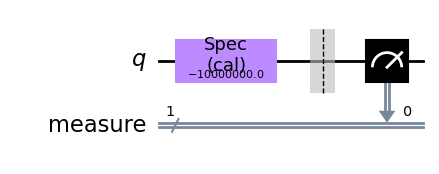

In [17]:
spec0.circuits()[0].draw(output="mpl")

Run the spectroscopy experiments.

In [18]:
%%time
spec0_data = spec0.run().block_for_results()
spec1_data = spec1.run().block_for_results()

CPU times: user 4.26 s, sys: 192 ms, total: 4.45 s
Wall time: 4.01 s


Plot the simulated data for both qubits.

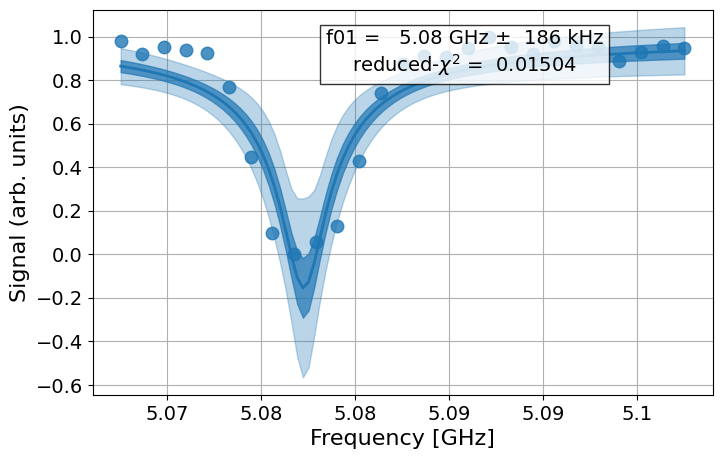

In [19]:
spec0_data.figure(0)

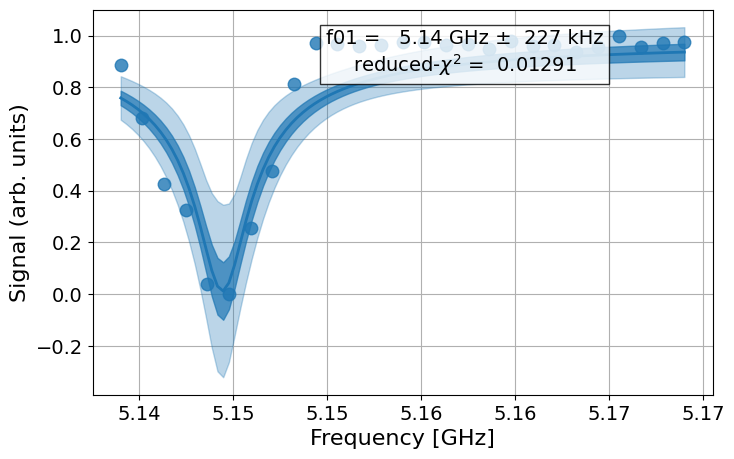

In [20]:
spec1_data.figure(0)

### 5.4 Rough amplitude calibration

Next, run a rough amplitude calibration for `X` and `SX` gates for both qubits. First, build the experiments.

In [21]:
from qiskit_experiments.library.calibration import RoughXSXAmplitudeCal

# rabi experiments for qubit 0
rabi0 = RoughXSXAmplitudeCal(0, cals, backend=backend, amplitudes=np.linspace(-0.2, 0.2, 27))

# rabi experiments for qubit 1
rabi1 = RoughXSXAmplitudeCal(1, cals, backend=backend, amplitudes=np.linspace(-0.2, 0.2, 27))

Run the Rabi experiments.

In [22]:
%%time
rabi0_data = rabi0.run().block_for_results()
rabi1_data = rabi1.run().block_for_results()

CPU times: user 6.93 s, sys: 227 ms, total: 7.15 s
Wall time: 6.52 s


Plot the results.

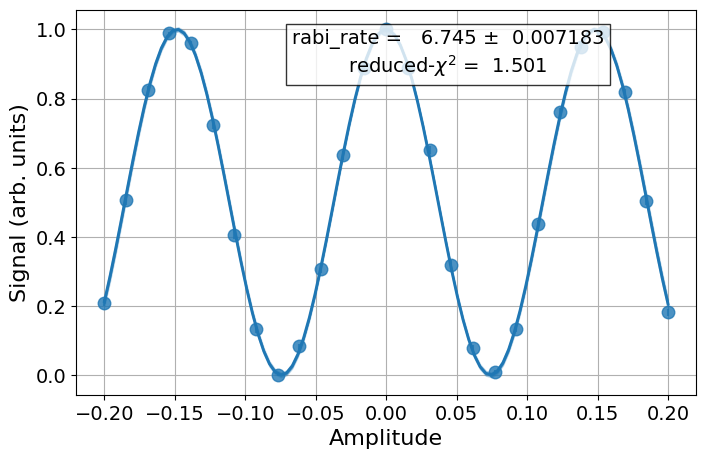

In [23]:
rabi0_data.figure(0)

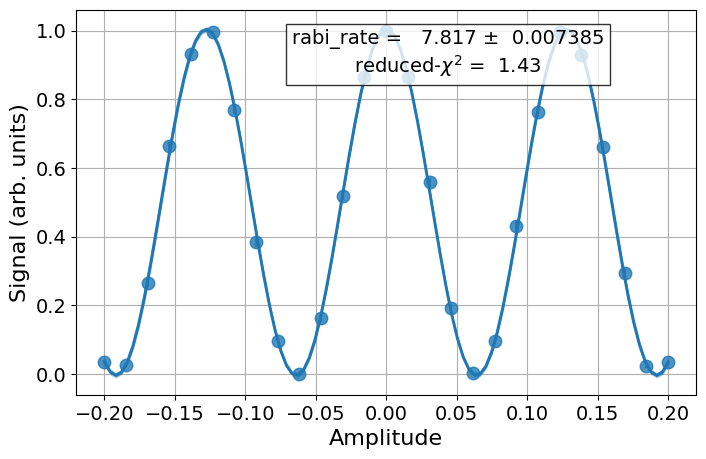

In [24]:
rabi1_data.figure(0)

Observe the updated parameters for qubit 0.

In [25]:
pd.DataFrame(**cals.parameters_table(qubit_list=[0, ()], parameters="amp"))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,amp,"(0,)",sx,0.037066+0.000000j,default,True,2023-02-14 10:26:44.347229-0800,b5fe15c2-b61e-4594-b3c1-22264d746af3
1,amp,(),x,0.500000+0.000000j,default,True,2023-02-14 10:26:32.651462-0800,None
2,amp,"(0,)",x,0.074133+0.000000j,default,True,2023-02-14 10:26:44.347229-0800,b5fe15c2-b61e-4594-b3c1-22264d746af3
3,amp,(),sx,0.500000+0.000000j,default,True,2023-02-14 10:26:32.658412-0800,None


### 5.5 Rough Drag parameter calibration

Run rough Drag parameter calibration for the `X` and `SX` gates. This follows the same procedure as above.

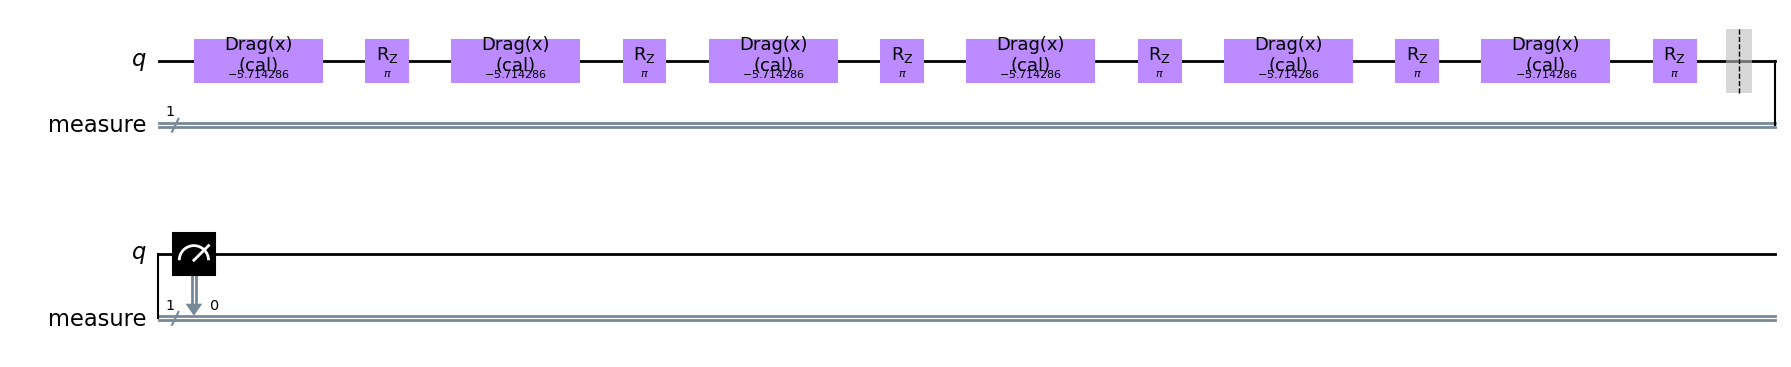

In [26]:
from qiskit_experiments.library.calibration import RoughDragCal

cal_drag0 = RoughDragCal(0, cals, backend=backend, betas=np.linspace(-20, 20, 15))
cal_drag1 = RoughDragCal(1, cals, backend=backend, betas=np.linspace(-20, 20, 15))

cal_drag0.set_experiment_options(reps=[3, 5, 7])
cal_drag1.set_experiment_options(reps=[3, 5, 7])

cal_drag0.circuits()[5].draw(output='mpl')

In [27]:
%%time
drag0_data = cal_drag0.run().block_for_results()
drag1_data = cal_drag1.run().block_for_results()

CPU times: user 28.5 s, sys: 2.01 s, total: 30.5 s
Wall time: 20.8 s


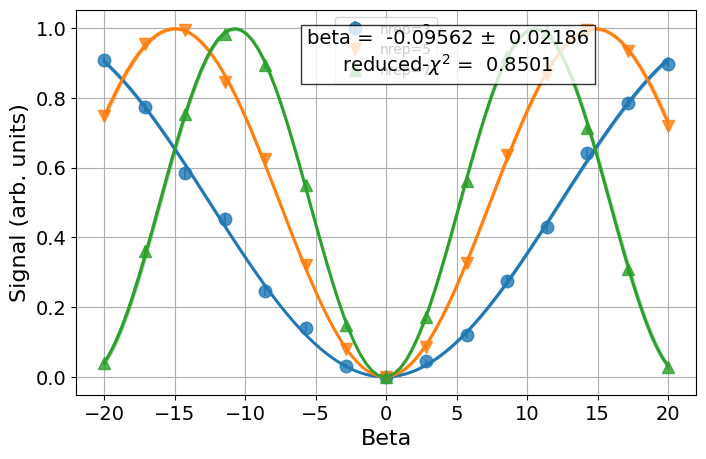

In [28]:
drag0_data.figure(0)

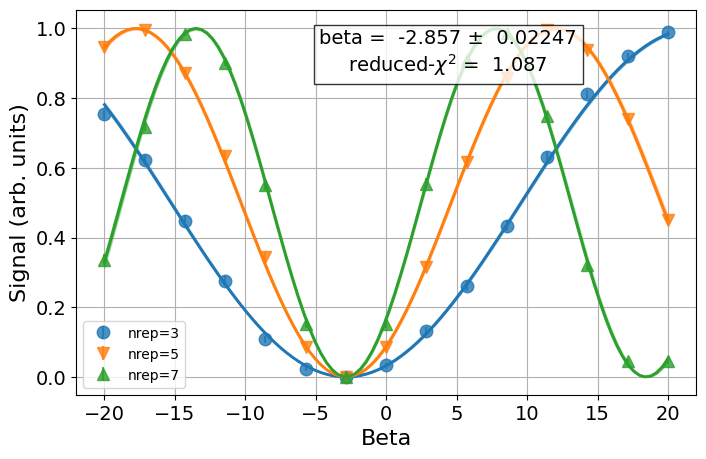

In [29]:
drag1_data.figure(0)

### 5.6 Fine amplitude calibration

Finally, run fine amplitude calibration for both qubits. Start with the `X` gate.

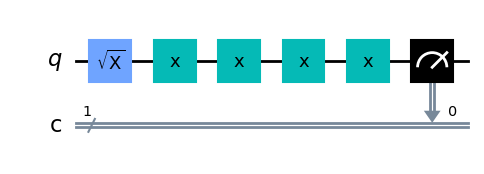

In [30]:
from qiskit_experiments.library.calibration.fine_amplitude import FineXAmplitudeCal

amp_x_cal0 = FineXAmplitudeCal(0, cals, backend=backend, schedule_name="x")
amp_x_cal1 = FineXAmplitudeCal(1, cals, backend=backend, schedule_name="x")

amp_x_cal0.circuits()[5].draw(output="mpl")

In [31]:
%%time
data_fine0 = amp_x_cal0.run().block_for_results()
data_fine1 = amp_x_cal1.run().block_for_results()

CPU times: user 7.54 s, sys: 405 ms, total: 7.95 s
Wall time: 6.2 s


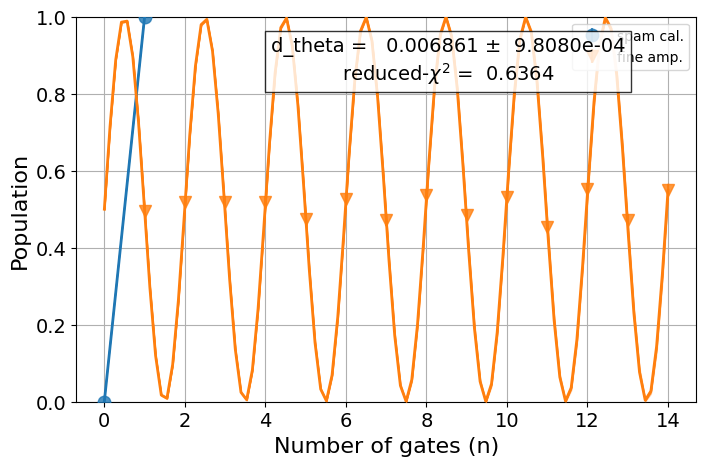

In [32]:
data_fine0.figure(0)

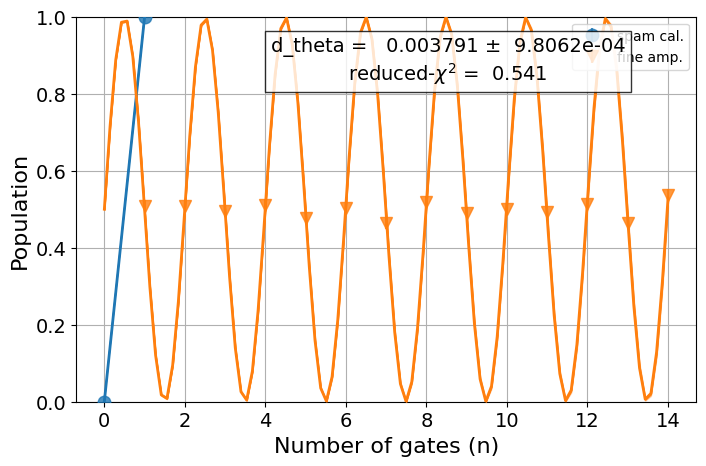

In [33]:
data_fine1.figure(0)

Next, run fine calibration on the `SX` gates.

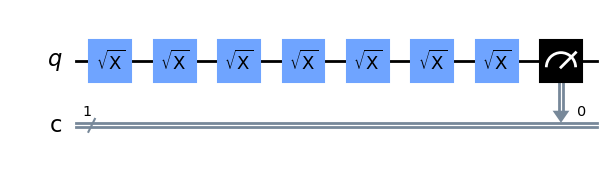

In [34]:
# Do SX Cal
from qiskit_experiments.library.calibration.fine_amplitude import FineSXAmplitudeCal

amp_sx_cal0 = FineSXAmplitudeCal(0, cals, backend=backend, schedule_name="sx")
amp_sx_cal1 = FineSXAmplitudeCal(1, cals, backend=backend, schedule_name="sx")

amp_sx_cal0.circuits()[5].draw(output="mpl")

In [35]:
%%time
data_fine_sx0 = amp_sx_cal0.run().block_for_results()
data_fine_sx1 = amp_sx_cal1.run().block_for_results()

CPU times: user 8.76 s, sys: 516 ms, total: 9.28 s
Wall time: 6.92 s


In [36]:
pd.DataFrame(**cals.parameters_table(qubit_list=[0, ()], parameters="amp"))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,amp,"(0,)",sx,0.036957+0.000000j,default,True,2023-02-14 10:27:24.125623-0800,bb75ce20-8c0a-4b3f-93d9-18674b5459fe
1,amp,(),x,0.500000+0.000000j,default,True,2023-02-14 10:26:32.651462-0800,None
2,amp,"(0,)",x,0.073971+0.000000j,default,True,2023-02-14 10:27:17.160785-0800,b5ccd4a7-2df8-4844-89f3-e444c5a14d93
3,amp,(),sx,0.500000+0.000000j,default,True,2023-02-14 10:26:32.658412-0800,None


## 6. Simulating a cross resonance characterization experiment

Finally, simulate the `CrossResonanceHamiltonian` characterization experiment. 

First, add the custom gate used in the experiment as a valid instruction in the `Target`.

In [37]:
from qiskit_experiments.library import CrossResonanceHamiltonian



backend.target.add_instruction(
    instruction=CrossResonanceHamiltonian.CRPulseGate(width=Parameter("width")), 
    properties={(0, 1): None, (1, 0): None}
)

Build the characterization experiment object, and set the instruction map in the transpilation options to use the single qubit gates calibrated above.

In [38]:
cr_ham_experiment = CrossResonanceHamiltonian(
    qubits=(0, 1), 
    flat_top_widths=np.linspace(0, 5000, 17), 
    backend=backend
)

cr_ham_experiment.set_transpile_options(inst_map=cals.default_inst_map)

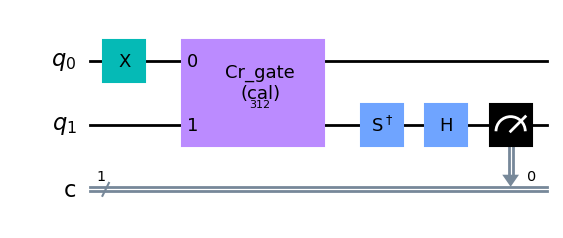

In [39]:
cr_ham_experiment.circuits()[10].draw("mpl")

Run the simulation.

In [40]:
%time data_cr = cr_ham_experiment.run().block_for_results()

CPU times: user 25.2 s, sys: 1.52 s, total: 26.7 s
Wall time: 20.3 s


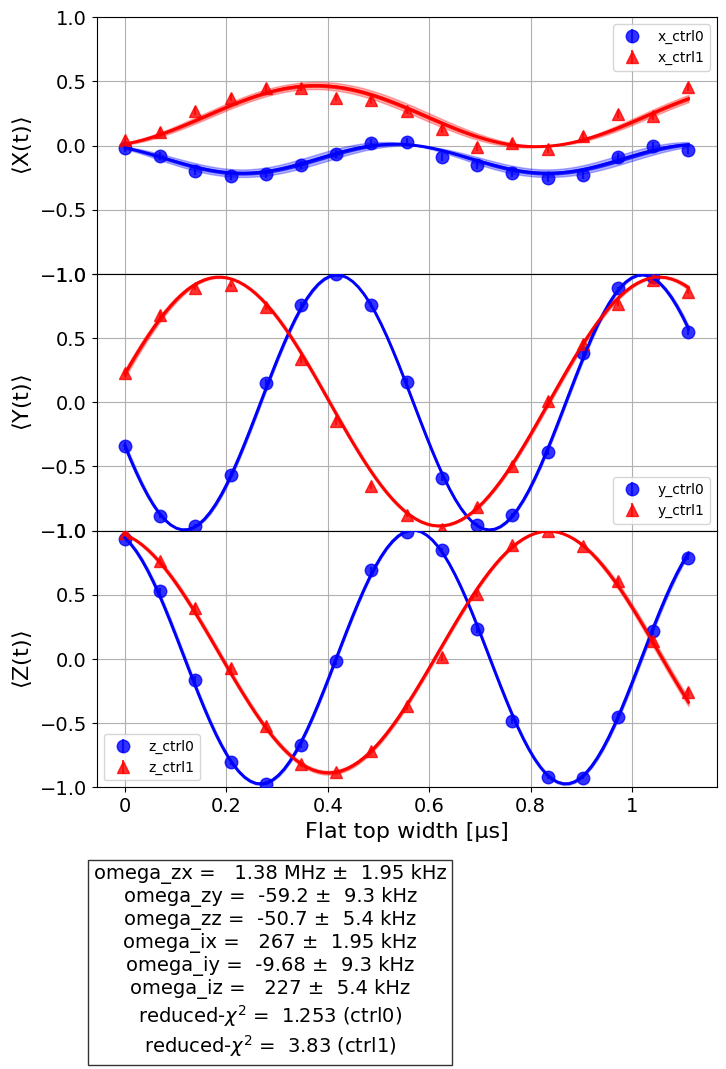

In [41]:
data_cr.figure(0)